In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Georgia

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  

The following counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release: Cobb, DeKalb, Gwinnett. Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election:

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary
Bartow: Split Cassville/Hamilton Crossing
Candler: Merge Candler/Metter as Jack Strickland Comm Center
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5 
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits 
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps
Towns: Merge Macedonia/Tate City

Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Candidate List

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
C20PRERTRU - Donald J. Trump (Republican Party)  
C20PREDBID - Joseph R. Biden (Democratic Party)  
C20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
G20USSRPER - David A. Perdue (Republican Party)  
G20USSDOSS - Jon Ossoff (Democratic Party)  
G20USSLHAZ - Shane Hazel (Libertarian Party)  
  
S20USSRLOE - Kelly Loeffler (Republican Party)  
S20USSRCOL - Doug Collins (Republican Party)  
S20USSRGRA - Derrick E. Grayson (Republican Party)  
S20USSRJAC - Annette Davis Jackson (Republican Party)  
S20USSRTAY - Kandiss Taylor (Republican Party)  
S20USSRJOH - A. Wayne Johnson (Republican Party)  
S20USSDWAR - Raphael Warnock (Democratic Party)  
S20USSDJAC - Deborah Jackson (Democratic Party)  
S20USSDLIE - Matt Lieberman (Democratic Party)  
S20USSDJOH - Tamara Johnson-Shealey (Democratic Party)  
S20USSDJAM - Jamesia James (Democratic Party)  
S20USSDSLA - Joy Felicia Slade (Democratic Party)  
S20USSDWIN - Richard Dien Winfield (Democratic Party)  
S20USSDTAR - Ed Tarver (Democratic Party)  
S20USSLSLO - Brian Slowinski (Libertarian Party)  
S20USSGFOR - John Fortuin (Green Party)  
S20USSIBUC - Allen Buckley (Independent)  
S20USSIBAR - Al Bartell (Independent)  
S20USSISTO - Valencia Stovall (Independent)  
S20USSIGRE - Michael Todd Greene (Independent)  
  
G20PSCRSHA - Jason Shaw (Republican Party)  
G20PSCDBRY - Robert G. Bryant (Democratic Party)  
G20PSCLMEL - Elizabeth Melton (Libertarian Party)  
  
G20PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
G20PSCDBLA - Daniel Blackman (Democratic Party)  
G20PSCLWIL - Nathan Wilson (Libertarian Party)  

### Load Non-Recount Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [2]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general = pd.DataFrame(z,columns=dfcols)

#### Take a look at the dataframe

In [250]:
df_general.head(1)

,county,contest,choice,voting_method,precinct,num_votes
0,Crisp,President of the United States,Donald J. Trump (I) (Rep),Election Day Votes,Arabi,163


### Load Recount Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [4]:
loaded_counties = os.listdir("./raw-from-source/Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_recount = pd.DataFrame(z,columns=dfcols)

#### Take a look at the dataframe

In [251]:
df_recount.head(2)

,county,contest,choice,voting_method,precinct,num_votes
0,Oconee,President-Recount,Donald J. Trump (I) (Rep),Election Day Votes,City Hall,244
1,Oconee,President-Recount,Donald J. Trump (I) (Rep),Election Day Votes,Colham Ferry,182


### Clean Recount Data - Contest Names

Note: Doing this before combining with the other data so the presidential vote tallies don't get mixed up

In [253]:
print(df_recount["contest"].unique())

contest_changes_dict = {'President of the United States':'President-Recount',
 'President of the United States/Presidentede los Estados Unidos':'President-Recount'}

df_recount["contest"] = df_recount["contest"].map(contest_changes_dict).fillna(df_recount["contest"])

['President-Recount']


### Join Election Data Together

In [7]:
ga_election = pd.concat([df_general,df_recount])

#Sanity check that there are the right number of counties, should be 159
print(len(ga_election["county"].unique()))

159


### Filter Down to Relevant Races

In [8]:
office_list = ['President of the United States','US Senate (Perdue)','US Senate (Loeffler) - Special',
              'Public Service Commission District 1','Public Service Commission District 4',
              'US Senate (Loeffler) - Special Election','President-Recount','President of the United States/Presidentede los Estados Unidos',
              'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1',
       'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4','US Senate (Perdue)/Senado de los EE.UU. (Perdue)',
       'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial',]

ga_election = ga_election[ga_election["contest"].isin(office_list)]

### Clean and Pivot Data

In [9]:
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4'
 'US Senate (Loeffler) - Special Election'
 'President of the United States/Presidentede los Estados Unidos'
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)'
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial'
 'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1'
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4'
 'President-Recount']


In [10]:
contest_changes_dict = {'US Senate (Loeffler) - Special Election':'US Senate (Loeffler) - Special',
                        'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial':'US Senate (Loeffler) - Special',
                        'US Senate (Perdue)/Senado de los EE.UU. (Perdue)':'US Senate (Perdue)',
                        'President of the United States/Presidentede los Estados Unidos':'President of the United States',
                        'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1':'Public Service Commission District 1',
                        'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4':'Public Service Commission District 4'}

ga_election["contest"] = ga_election["contest"].map(contest_changes_dict).fillna(ga_election["contest"])

#### Check remaining contests

In [11]:
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4' 'President-Recount']


### Clean Candidate Names

In [12]:
print(ga_election["choice"].unique())

['Donald J. Trump (I) (Rep)' 'Joseph R. Biden (Dem)' 'Jo Jorgensen (Lib)'
 'David A. Perdue (I) (Rep)' 'Jon Ossoff (Dem)' 'Shane Hazel (Lib)'
 'Al Bartell (Ind)' 'Allen Buckley (Ind)' 'Doug Collins (Rep)'
 'John Fortuin (Grn)' 'Derrick E. Grayson (Rep)'
 'Michael Todd Greene (Ind)' 'Annette Davis Jackson (Rep)'
 'Deborah Jackson (Dem)' 'Jamesia James (Dem)' 'A. Wayne Johnson (Rep)'
 'Tamara Johnson-Shealey (Dem)' 'Matt Lieberman (Dem)'
 'Kelly Loeffler (I) (Rep)' 'Joy Felicia Slade (Dem)'
 'Brian Slowinski (Lib)' 'Valencia Stovall (Ind)' 'Ed Tarver (Dem)'
 'Kandiss Taylor (Rep)' 'Raphael Warnock (Dem)'
 'Richard Dien Winfield (Dem)' 'Jason Shaw (I) (Rep)'
 'Robert G. Bryant (Dem)' 'Elizabeth Melton (Lib)'
 'Lauren Bubba McDonald, Jr. (I) (Rep)' 'Daniel Blackman (Dem)'
 'Nathan Wilson (Lib)' 'Matt Lierberman (Dem)']


#### Correct the Candidate Name Typo

In [13]:
cand_change_dict = {'Matt Lierberman (Dem)':'Matt Lieberman (Dem)'}
ga_election["choice"] = ga_election["choice"].map(cand_change_dict).fillna(ga_election["choice"])

In [14]:
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

#### Add a FIPS Column

In [15]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

#### Pivot the data

In [16]:
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]
ga_election["choice"]=ga_election["choice"]+ga_election["contest"]
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

#### Change Names to match VEST

In [18]:
column_changes_dict = {'A. Wayne Johnson (Rep)US Senate (Loeffler) - Special':'S20USSRJOH',
       'Al Bartell (Ind)US Senate (Loeffler) - Special':'S20USSIBAR',
       'Allen Buckley (Ind)US Senate (Loeffler) - Special':'S20USSIBUC',
       'Annette Davis Jackson (Rep)US Senate (Loeffler) - Special':'S20USSRJAC',
       'Brian Slowinski (Lib)US Senate (Loeffler) - Special':'S20USSLSLO',
       'Daniel Blackman (Dem)Public Service Commission District 4':'G20PSCDBLA',
       'David A. Perdue (I) (Rep)US Senate (Perdue)':'G20USSRPER',
       'Deborah Jackson (Dem)US Senate (Loeffler) - Special':'S20USSDJAC',
       'Derrick E. Grayson (Rep)US Senate (Loeffler) - Special':'S20USSRGRA',
       'Donald J. Trump (I) (Rep)President of the United States':'G20PRERTRU',
       'Donald J. Trump (I) (Rep)President-Recount':'C20PRERTRU',
       'Doug Collins (Rep)US Senate (Loeffler) - Special':'S20USSRCOL',
       'Ed Tarver (Dem)US Senate (Loeffler) - Special':'S20USSDTAR',
       'Elizabeth Melton (Lib)Public Service Commission District 1':'G20PSCLMEL',
       'Jamesia James (Dem)US Senate (Loeffler) - Special':'S20USSDJAM',
       'Jason Shaw (I) (Rep)Public Service Commission District 1':'G20PSCRSHA',
       'Jo Jorgensen (Lib)President of the United States':'G20PRELJOR',
       'Jo Jorgensen (Lib)President-Recount':'C20PRELJOR',
       'John Fortuin (Grn)US Senate (Loeffler) - Special':'S20USSGFOR',
       'Jon Ossoff (Dem)US Senate (Perdue)':'G20USSDOSS',
       'Joseph R. Biden (Dem)President of the United States':'G20PREDBID',
       'Joseph R. Biden (Dem)President-Recount':'C20PREDBID',
       'Joy Felicia Slade (Dem)US Senate (Loeffler) - Special':'S20USSDSLA',
       'Kandiss Taylor (Rep)US Senate (Loeffler) - Special':'S20USSRTAY',
       'Kelly Loeffler (I) (Rep)US Senate (Loeffler) - Special':'S20USSRLOE',
       'Lauren Bubba McDonald, Jr. (I) (Rep)Public Service Commission District 4':'G20PSCRMCD',
       'Matt Lieberman (Dem)US Senate (Loeffler) - Special':'S20USSDLIE',
       'Michael Todd Greene (Ind)US Senate (Loeffler) - Special':'S20USSIGRE',
       'Nathan Wilson (Lib)Public Service Commission District 4':'G20PSCLWIL',
       'Raphael Warnock (Dem)US Senate (Loeffler) - Special':'S20USSDWAR',
       'Richard Dien Winfield (Dem)US Senate (Loeffler) - Special':'S20USSDWIN',
       'Robert G. Bryant (Dem)Public Service Commission District 1':'G20PSCDBRY',
       'Shane Hazel (Lib)US Senate (Perdue)':'G20USSLHAZ',
       'Tamara Johnson-Shealey (Dem)US Senate (Loeffler) - Special':'S20USSDJOH',
       'Valencia Stovall (Ind)US Senate (Loeffler) - Special':'S20USSISTO'}

ga_election = ga_election.rename(columns=column_changes_dict)

#### Order election result columns to match VEST

In [19]:
ga_election = ga_election[['unique_ID', 'county', 'county_fips', 'precinct','G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL']]

In [20]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/ga_2020/ga_2020.shp")

In [255]:
vest_ga_20.head(1)

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
0,215122,215122,122,FIRST AFRICAN,MUSCOGEE,106,106,215,238,668,...,1,4,251,587,52,251,587,44,"POLYGON ((-84.96984 32.46725, -84.97031 32.467...",215-FIRST AFRICAN


In [22]:
ga_election['FIPS2'] = ga_election["county_fips"]

In [23]:
data_columns = ['G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL']

for race in data_columns:
    ga_election[race] = ga_election[race].astype(int)

### Compare Race Totals

In [265]:
no_diff = True
for race in data_columns:
    if (sum(vest_ga_20[race])-sum(ga_election[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_ga_20[race])-sum(ga_election[race]))+" votes")
        print("\tVEST: "+str(sum(vest_ga_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(ga_election[race]))+" votes")
        no_diff = False
if (no_diff):
    print("No races contain vote differences")
else:
    print("All other races are equal")

No races contain vote differences


### Compare County-by-County Totals

In [266]:
no_diff = True
diff_counties=[]
for i in data_columns:
    diff = vest_ga_20.groupby(["FIPS2"]).sum()[i]-ga_election.groupby(["FIPS2"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
        no_diff = False
if (no_diff):
    print("No counties contain vote differences")
else:
    print("All other county race totals are equal")

No counties contain vote differences


In [28]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_I"]

join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

right_only    2067
left_only     2044
both           612
Name: _merge, dtype: int64


In [29]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

In [30]:
print(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])



      DISTRICT  CTYSOSID PRECINCT_I           PRECINCT_N  CTYNAME CTYNUMBER  \
2245  0513-15C  0513-15C      3-15C  ELI WHITNEY COMPLEX  CHATHAM        25   
2247  0512-06C  0512-06C      2-06C  ELI WHITNEY COMPLEX  CHATHAM        25   

     CTYNUMBER2 FIPS2  G20PRERTRU  G20PREDBID  ...  S20USSISTO  S20USSIGRE  \
2245        025   051         278         361  ...           0           1   
2247        025   051          65         335  ...           2           1   

      G20PSCRSHA  G20PSCDBRY  G20PSCLMEL  G20PSCRMCD  G20PSCDBLA  G20PSCLWIL  \
2245         301         320          16         290         325          15   
2247          72         294          25          67         301          19   

                                               geometry  \
2245  POLYGON ((-81.02948 32.06200, -81.03000 32.060...   
2247  POLYGON ((-81.05333 32.07291, -81.05336 32.072...   

                    unique_ID  
2245  051-ELI WHITNEY COMPLEX  
2247  051-ELI WHITNEY COMPLEX  

[2 rows x 4

In [31]:
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [32]:
print(ga_election["unique_ID"].value_counts())
print(vest_ga_20["unique_ID"].value_counts())

121-RW10                    1
051-7-03C PB EDWARDS GYM    1
161-OCMULGEE 2              1
089-VALLEY BROOK            1
135-PINCKNEYVILLE J         1
                           ..
121-08N2                    1
121-CP04B                   1
067-HARMONY-LELAND 01       1
067-POWDERS SPRINGS 3A      1
169-FINNEY                  1
Name: unique_ID, Length: 2656, dtype: int64
121-RW10                1
193-IDEAL               1
273-GRAVES              1
067-KENNESAW 5A         1
089-VALLEY BROOK        1
                       ..
075-DELLE BEAMGUARD     1
021-HOWARD 6            1
089-BRIAR VISTA ELEM    1
229-PATTERSON           1
009-EAST BALDWIN        1
Name: unique_ID, Length: 2672, dtype: int64


In [33]:
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

both          2545
right_only     134
left_only      111
Name: _merge, dtype: int64


In [34]:
left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]



In [35]:
example_csv = pd.read_csv("./source_vest_id_changes.csv")
example_fips_dict = dict(zip(example_csv["source_ID"],example_csv["vest_ID"]))

In [36]:
ga_election["unique_ID"] = ga_election["unique_ID"].map(example_fips_dict).fillna(ga_election["unique_ID"])

In [37]:
join_attempt_2 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both = join_attempt_2[join_attempt_2["_merge"]=="both"]
left_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
right_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]

left_only.to_csv("./source_only.csv")
right_only.to_csv("./VEST_only.csv")

both          2656
right_only      23
left_only        0
Name: _merge, dtype: int64


In [38]:
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race+"_y"]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


In [39]:
print(empty_precincts)

['121AP01E', '121UC033', '12103P1B', '121AP12D', '121SC29B', '121CP06B', '121CP053', '121SC07B', '121RW22B', '121SC08A', '121SC21A', '121UC01C', '121CP052', '051XFTPU', '029FTSTEW', '215FTBEN2', '215FTBEN4', '215FTBEN3', '215ZZZZZZ', '215FTBEN1', '121RW11B', '12108F2', '12112E2']


In [40]:
vest_ga_20[vest_ga_20["DISTRICT"].isin(empty_precincts)]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
249,121AP01E,121AP01E,AP01E,AP01E,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.29795 34.03893, -84.29797 34.037...",121-AP01E
250,121UC033,121UC033,UC033,UC033,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-84.50565 33.58889, -84.50668 ...",121-UC033
679,12103P1B,12103P1B,03P1B,03P1B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.40813 33.77318, -84.40764 33.773...",121-03P1B
688,121AP12D,121AP12D,AP12D,AP12D,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.25836 34.09181, -84.25818 34.091...",121-AP12D
887,121SC29B,121SC29B,SC29B,SC29B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.51576 33.58520, -84.51580 33.585...",121-SC29B
935,121CP06B,121CP06B,CP06B,CP06B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.46700 33.62007, -84.47102 33.620...",121-CP06B
951,121CP053,121CP053,CP053,CP053,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.48197 33.62309, -84.48200 33.623...",121-CP053
955,121SC07B,121SC07B,SC07B,SC07B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.58213 33.62434, -84.58229 33.624...",121-SC07B
966,121RW22B,121RW22B,RW22B,RW22B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.27466 33.99256, -84.27435 33.992...",121-RW22B
999,121SC08A,121SC08A,SC08A,SC08A,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.55685 33.60644, -84.55673 33.606...",121-SC08A


In [41]:
empty_unjoined = vest_ga_20[vest_ga_20["DISTRICT"].isin(empty_precincts)]
empty_unjoined.loc[empty_unjoined['unique_ID'].isna(), 'unique_ID'] = empty_unjoined['DISTRICT']

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [42]:
print(empty_unjoined)

       DISTRICT  CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
249    121AP01E  121AP01E      AP01E      AP01E  FULTON        60        060   
250    121UC033  121UC033      UC033      UC033  FULTON        60        060   
679    12103P1B  12103P1B      03P1B      03P1B  FULTON        60        060   
688    121AP12D  121AP12D      AP12D      AP12D  FULTON        60        060   
887    121SC29B  121SC29B      SC29B      SC29B  FULTON        60        060   
935    121CP06B  121CP06B      CP06B      CP06B  FULTON        60        060   
951    121CP053  121CP053      CP053      CP053  FULTON        60        060   
955    121SC07B  121SC07B      SC07B      SC07B  FULTON        60        060   
966    121RW22B  121RW22B      RW22B      RW22B  FULTON        60        060   
999    121SC08A  121SC08A      SC08A      SC08A  FULTON        60        060   
1002   121SC21A  121SC21A      SC21A      SC21A  FULTON        60        060   
1004   121UC01C  121UC01C      UC01C    

In [43]:
empty_unjoined = empty_unjoined[["unique_ID","CTYNAME","FIPS2","PRECINCT_N",'S20USSRJOH',
       'S20USSIBAR', 'S20USSIBUC', 'S20USSRJAC', 'S20USSLSLO', 'G20PSCDBLA',
       'G20USSRPER', 'S20USSDJAC', 'S20USSRGRA', 'G20PRERTRU', 'C20PRERTRU',
       'S20USSRCOL', 'S20USSDTAR', 'G20PSCLMEL', 'S20USSDJAM', 'G20PSCRSHA',
       'G20PRELJOR', 'C20PRELJOR', 'S20USSGFOR', 'G20USSDOSS', 'G20PREDBID',
       'C20PREDBID', 'S20USSDSLA', 'S20USSRTAY', 'S20USSRLOE', 'G20PSCRMCD',
       'S20USSDLIE', 'S20USSIGRE', 'G20PSCLWIL', 'S20USSDWAR', 'S20USSDWIN',
       'G20PSCDBRY', 'G20USSLHAZ', 'S20USSDJOH', 'S20USSISTO', 'FIPS2']]

empty_unjoined.columns = ga_election.columns



In [44]:
empty_unjoined.columns = ga_election.columns

In [45]:
print(empty_unjoined)

choice  unique_ID  county county_fips precinct  G20PRERTRU  G20PREDBID  \
249     121-AP01E  FULTON         121    AP01E           0           0   
250     121-UC033  FULTON         121    UC033           0           0   
679     121-03P1B  FULTON         121    03P1B           0           0   
688     121-AP12D  FULTON         121    AP12D           0           0   
887     121-SC29B  FULTON         121    SC29B           0           0   
935     121-CP06B  FULTON         121    CP06B           0           0   
951     121-CP053  FULTON         121    CP053           0           0   
955     121-SC07B  FULTON         121    SC07B           0           0   
966     121-RW22B  FULTON         121    RW22B           0           0   
999     121-SC08A  FULTON         121    SC08A           0           0   
1002    121-SC21A  FULTON         121    SC21A           0           0   
1004    121-UC01C  FULTON         121    UC01C           0           0   
1301    121-CP052  FULTON         121 

In [46]:
ga_election = pd.concat([ga_election,empty_unjoined])

In [47]:
print(vest_ga_20.loc[vest_ga_20['unique_ID'].isna()])
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']
print(vest_ga_20.loc[vest_ga_20['unique_ID'].isna()])

       DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
1329   051XFTPU     None       None       None    None      None       None   
1447  029FTSTEW     None       None       None    None      None       None   
2125  215FTBEN2     None       None       None    None      None       None   
2128  215FTBEN4     None       None       None    None      None       None   
2146  215FTBEN3     None       None       None    None      None       None   
2229  215ZZZZZZ     None       None       None    None      None       None   
2230  215FTBEN1     None       None       None    None      None       None   

     FIPS2  G20PRERTRU  G20PREDBID  ...  S20USSISTO  S20USSIGRE  G20PSCRSHA  \
1329  None           0           0  ...           0           0           0   
1447  None           0           0  ...           0           0           0   
2125  None           0           0  ...           0           0           0   
2128  None           0           0  ...           0

In [48]:
join_attempt_2 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both = join_attempt_2[join_attempt_2["_merge"]=="both"]
left_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
right_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]

left_only.to_csv("./source_only.csv")
right_only.to_csv("./VEST_only.csv")

both          2679
left_only        0
right_only       0
Name: _merge, dtype: int64


In [49]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)
    
validater_row(both,data_columns)


There are  2679  total rows
0  of these rows have election result differences
2679  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


## Shapefiles 

In [156]:
shapefiles_state = gp.read_file("./raw-from-source/Shapefiles/vtd2020-shape-4-20-21/VTD2020-Shape.shp")

In [157]:
vest_ga_20[vest_ga_20["FIPS2"]=="089"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
1630,089BM,089BM,BM,BETHUNE MIDDLE,DEKALB,44,044,089,138,2698,...,9,9,124,2612,63,113,2612,44,"POLYGON ((-84.21738 33.71163, -84.21735 33.711...",089-BETHUNE MIDDLE
1631,089KG,089KG,KG,KITTREDGE ELEM,DEKALB,44,044,089,734,1079,...,0,2,853,865,81,835,884,79,"POLYGON ((-84.33197 33.90557, -84.33176 33.905...",089-KITTREDGE ELEM
1632,089MT,089MT,MT,METROPOLITAN,DEKALB,44,044,089,161,2304,...,3,7,194,2135,127,197,2145,102,"POLYGON ((-84.34925 33.73940, -84.34925 33.739...",089-METROPOLITAN
1633,089GB,089GB,GB,GLENHAVEN,DEKALB,44,044,089,123,999,...,5,2,114,965,39,109,965,26,"POLYGON ((-84.22325 33.76380, -84.22205 33.763...",089-GLENHAVEN
1634,089HH,089HH,HH,HARRIS-NARVIE J HARRIS ELEM,DEKALB,44,044,089,91,2537,...,10,5,70,2507,63,79,2500,52,"POLYGON ((-84.28207 33.66013, -84.28204 33.660...",089-HARRIS-NARVIE J HARRIS ELEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,089ME,089ME,ME,MCLENDON,DEKALB,44,044,089,423,2025,...,7,10,423,1889,139,424,1893,107,"POLYGON ((-84.28073 33.80023, -84.27976 33.801...",089-MCLENDON
2093,089CY,089CY,CY,CLARKSTON COMMUNITY CENTER,DEKALB,44,044,089,213,1202,...,5,5,204,1110,81,179,1127,55,"POLYGON ((-84.26392 33.79360, -84.26352 33.794...",089-CLARKSTON COMMUNITY CENTER
2094,089MP,089MP,MP,MCNAIR ACADEMY,DEKALB,44,044,089,53,1213,...,4,2,61,1157,46,54,1160,35,"POLYGON ((-84.30968 33.73438, -84.30968 33.734...",089-MCNAIR ACADEMY
2095,089PN,089PN,PN,PINEY GROVE,DEKALB,44,044,089,62,1042,...,6,2,68,989,29,69,981,23,"POLYGON ((-84.32939 33.73983, -84.32930 33.739...",089-PINEY GROVE


In [158]:
filtered_fulton = shapefiles_state[shapefiles_state["FIPS2"]=="121"]

In [159]:
#Filter out Cobb, Gwinnett, and DeKalb

In [160]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties
fips_codes = ["13135","13067","13089"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Shapefiles/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

<AxesSubplot:>

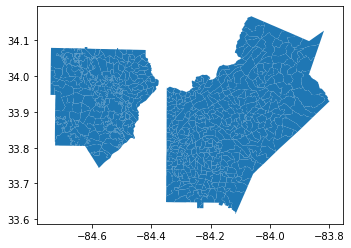

In [161]:
shapefiles_census.plot()

In [162]:
shapefiles_fulton = gp.read_file("./raw-from-source/Shapefiles/Fulton/Voting_Precincts/Voting_Precincts.shp")

In [163]:
shapefiles_forsyth  = gp.read_file("./raw-from-source/Shapefiles/Forsyth/Voting_Precinct-shp/Voting_Precinct.shp")

In [164]:
print(shapefiles_census.head())

  STATEFP COUNTYFP   VTDST      NAMELSAD VTDI LSAD CHNG_TYPE ORIG_NAME  \
0      13      135  000001     HARBINS A    A   00      None      None   
1      13      135  000002  ROCKBRIDGE A    A   00      None      None   
2      13      135  000003        DACULA    A   00      None      None   
3      13      135  000004     SUWANEE A    A   00      None      None   
4      13      135  000028  ROCKYCREEK A    A   00      None      None   

  ORIG_CODE RELATE          NAME VINTAGE FUNCSTAT JUSTIFY  MTFCC  \
0      None   None     HARBINS A      90        N    None  G5240   
1      None   None  ROCKBRIDGE A      90        N    None  G5240   
2      None   None        DACULA      90        N    None  G5240   
3      None   None     SUWANEE A      90        N    None  G5240   
4      None   None  ROCKYCREEK A      90        N    None  G5240   

                                            geometry  
0  POLYGON Z ((-83.92720 33.95932 0.00000, -83.92...  
1  POLYGON Z ((-84.07069 33.80553 0.

In [165]:
print(shapefiles_state.columns)

Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CNTY', 'FIPS2', 'CTYNAME',
       ...
       'UKNMALEREG', 'UKNMALEVOT', 'UNKMALEVOT', 'UKNFMREG20', 'UKNFMVOTED',
       'UKNFMVOTE1', 'UKNOWNREG2', 'UKNOWNVOTE', 'UKNOWVOTED', 'geometry'],
      dtype='object', length=116)


In [166]:
#Cobb, Gwinnett and DeKalb
"13135","13067","13089"

#Fulton and Forsyth
"13121","13117"

filter_list = ["135","067","089","121","117"]

filter_list_mod = ["135","067","089","117"]

shapefiles_state = shapefiles_state[~shapefiles_state["FIPS2"].isin(filter_list_mod)]

epsg:4019


<AxesSubplot:>

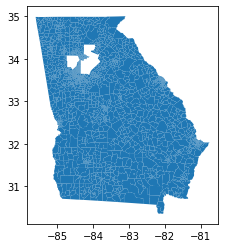

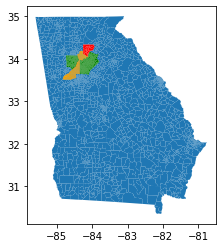

In [167]:
print(vest_ga_20.crs)

shapefiles_forsyth = shapefiles_forsyth.to_crs(4019)
shapefiles_fulton = shapefiles_fulton.to_crs(4019)
shapefiles_census = shapefiles_census.to_crs(4019)

shapefiles_state.plot()

ax = shapefiles_state.plot()
shapefiles_forsyth.plot(ax = ax,color="red")
shapefiles_fulton.plot(ax = ax,color="orange")
shapefiles_census.plot(ax = ax,color="green")

In [168]:
print(shapefiles_state.columns)
print(shapefiles_forsyth.columns)
print(shapefiles_fulton.columns)
print(shapefiles_census.columns)

Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CNTY', 'FIPS2', 'CTYNAME',
       ...
       'UKNMALEREG', 'UKNMALEVOT', 'UNKMALEVOT', 'UKNFMREG20', 'UKNFMVOTED',
       'UKNFMVOTE1', 'UKNOWNREG2', 'UKNOWNVOTE', 'UKNOWVOTED', 'geometry'],
      dtype='object', length=116)
Index(['OBJECTID', 'PRECINCTID', 'NAME', 'COUNTY', 'Shape__Are', 'Shape__Len',
       'geometry'],
      dtype='object')
Index(['OBJECTID', 'ProposalNo', 'Status', 'RetireStat', 'VoterDist',
       'TurnOut', 'ActVoters', 'FeatureID', 'FacilityID', 'PrecinctN',
       'ShapeSTAre', 'ShapeSTLen', 'geometry'],
      dtype='object')
Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'geometry'],
      dtype='object')


In [169]:
print(shapefiles_state.head())

   ID      AREA  DATA DISTRICT CTYSOSID PRECINCT_I            PRECINCT_N CNTY  \
0   1  3.383541   687   073131   073131        131  JOURNEY COMM. CHURCH  036   
1   2  1.636596   667   073064   073064        064  GRACE BAPTIST CHURCH  036   
2   3  5.598643   664   073061   073061        061       GREENBRIER HIGH  036   
3   4  0.872412   666   073063   073063        063      RIVERVIEW CHURCH  036   
4   5  2.609909   688   073132   073132        132      WESLEY METHODIST  036   

  FIPS2   CTYNAME  ...  UKNMALEREG  UKNMALEVOT  UNKMALEVOT  UKNFMREG20  \
0   073  COLUMBIA  ...        40.0        25.0   62.500000        42.0   
1   073  COLUMBIA  ...       167.0        86.0   51.500000       162.0   
2   073  COLUMBIA  ...       158.0        92.0   58.230000       169.0   
3   073  COLUMBIA  ...        43.0        33.0   76.739998        47.0   
4   073  COLUMBIA  ...        94.0        59.0   62.770000       112.0   

   UKNFMVOTED  UKNFMVOTE1  UKNOWNREG2  UKNOWNVOTE  UKNOWVOTED  \
0  

In [170]:
shapefiles_state = shapefiles_state[['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CNTY','CTYNAME','FIPS2','geometry']]
shapefiles_forsyth = shapefiles_forsyth[["PRECINCTID","NAME","COUNTY","geometry"]]
shapefiles_fulton = shapefiles_fulton[["OBJECTID","VoterDist","geometry"]]
shapefiles_census = shapefiles_census[["STATEFP","COUNTYFP","VTDST","NAMELSAD","NAME","geometry"]]

In [171]:
print(vest_ga_20.columns)

shapefile_col_list = ['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME','CTYNUMBER2', 'FIPS2','geometry']

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'geometry', 'unique_ID'],
      dtype='object')


In [172]:
shapefiles_state.loc[:,"CTYNUMBER2"] = shapefiles_state.loc[:,"CNTY"]

shapefiles_state = shapefiles_state[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [173]:
print(shapefiles_forsyth.head())

shapefiles_forsyth.loc[:,"DISTRICT"] = "117"+ shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"CTYSOSID"] = shapefiles_forsyth.loc[:,"DISTRICT"]
shapefiles_forsyth.loc[:,"PRECINCT_I"] = shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"PRECINCT_N"] = shapefiles_forsyth.loc[:,"PRECINCTID"] + " " + shapefiles_forsyth.loc[:,"NAME"]
shapefiles_forsyth.loc[:,"CTYNAME"] = "FORSYTH"
shapefiles_forsyth.loc[:,"CTYNUMBER2"] = "058"
shapefiles_forsyth.loc[:,"FIPS2"] = "117"

shapefiles_forsyth = shapefiles_forsyth[shapefile_col_list]

  PRECINCTID           NAME   COUNTY  \
0         27        CONCORD  Forsyth   
1         06     CROSSROADS  Forsyth   
2         04      CHESTATEE  Forsyth   
3         03  BROWNS BRIDGE  Forsyth   
4         05  COAL MOUNTAIN  Forsyth   

                                            geometry  
0  POLYGON ((-84.16395 34.29828, -84.16402 34.298...  
1  POLYGON ((-83.97539 34.30389, -83.97550 34.303...  
2  POLYGON ((-83.94688 34.30902, -83.94620 34.308...  
3  POLYGON ((-84.09370 34.25201, -84.09327 34.252...  
4  POLYGON ((-84.07448 34.29508, -84.07471 34.292...  


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [174]:
shapefiles_fulton.head()

shapefiles_fulton.loc[:,"DISTRICT"] = "121"+ shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYSOSID"] = shapefiles_fulton.loc[:,"DISTRICT"]
shapefiles_fulton.loc[:,"PRECINCT_I"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"PRECINCT_N"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYNAME"] = "FULTON"
shapefiles_fulton.loc[:,"CTYNUMBER2"] = "060"
shapefiles_fulton.loc[:,"FIPS2"] = "121"

shapefiles_fulton = shapefiles_fulton[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [175]:
name_map_dict = {"135":"GWINNETT","067":"COBB","089":"DEKALB"}
num_map_dict = {"135":"067","067":"033","089":"044"}


shapefiles_census.loc[:,"PRECINCT_I"] = shapefiles_census.loc[:,"VTDST"].str[3:]
shapefiles_census.loc[:,"DISTRICT"] = shapefiles_census.loc[:,"COUNTYFP"]+ shapefiles_census.loc[:,"PRECINCT_I"]
shapefiles_census.loc[:,"CTYSOSID"] = shapefiles_census.loc[:,"DISTRICT"]

shapefiles_census.loc[:,"PRECINCT_N"] = shapefiles_census.loc[:,"NAME"]
shapefiles_census.loc[:,"CTYNAME"] = shapefiles_census.loc[:,"COUNTYFP"].map(name_map_dict)
shapefiles_census.loc[:,"CTYNUMBER2"] = shapefiles_census.loc[:,"COUNTYFP"].map(num_map_dict)
shapefiles_census.loc[:,"FIPS2"] = shapefiles_census.loc[:,"COUNTYFP"]

shapefiles_census = shapefiles_census[shapefile_col_list]

In [210]:
ga_shapefile = pd.concat([shapefiles_census,shapefiles_state,shapefiles_fulton,shapefiles_forsyth])
ga_shapefile = pd.concat([shapefiles_census,shapefiles_state,shapefiles_forsyth])
ga_shapefile.reset_index(inplace=True,drop=True)

In [211]:
ga_shapefile["PRECINCT_N"] =ga_shapefile["PRECINCT_N"].str.upper()
ga_shapefile["unique_ID"] = ga_shapefile["FIPS2"]+"-"+ga_shapefile["PRECINCT_N"]

In [212]:
ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]
na_dist_list = ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]["DISTRICT"]

In [213]:
ga_shapefile.loc[(ga_shapefile['unique_ID'].isna())&(ga_shapefile['DISTRICT'].str[0:3]=="121"), 'unique_ID'] = ga_shapefile.loc[:,'DISTRICT'].str[0:3]+"-"+ga_shapefile.loc[:,'DISTRICT'].str[3:]
ga_shapefile.loc[ga_shapefile['unique_ID'].isna(), 'unique_ID'] = ga_shapefile.loc[:,'DISTRICT']

In [214]:
ga_shapefile[ga_shapefile["DISTRICT"].isin(na_dist_list)]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
537,121CH04B,None,None,None,None,None,None,"POLYGON ((-84.66472 33.54058, -84.66442 33.540...",121-CH04B
586,121CP06B,None,None,None,None,None,None,"POLYGON ((-84.47425 33.62469, -84.47392 33.624...",121-CP06B
601,121UC01C,None,None,None,None,None,None,"MULTIPOLYGON (((-84.50531 33.59696, -84.50529 ...",121-UC01C
602,121UC033,None,None,None,None,None,None,"MULTIPOLYGON (((-84.49907 33.59374, -84.49815 ...",121-UC033
610,121SC29B,None,None,None,None,None,None,"POLYGON ((-84.51476 33.58541, -84.51463 33.585...",121-SC29B
611,121UC035,None,None,None,None,None,None,"MULTIPOLYGON (((-84.50786 33.58318, -84.50733 ...",121-UC035
976,215FTBEN2,None,None,None,None,None,None,"POLYGON ((-84.89301 32.40081, -84.89311 32.400...",215FTBEN2
977,215FTBEN4,None,None,None,None,None,None,"POLYGON ((-84.92604 32.42313, -84.92521 32.423...",215FTBEN4
979,215FTBEN1,None,None,None,None,None,None,"POLYGON ((-84.89265 32.40096, -84.89301 32.400...",215FTBEN1
1004,053FTBEN3,None,None,None,None,None,None,"POLYGON ((-84.95757 32.31050, -84.95784 32.310...",053FTBEN3


### Shapefile Updates

#### Fort Benning

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

     DISTRICT CTYSOSID PRECINCT_I       PRECINCT_N        CTYNAME CTYNUMBER2  \
1016     0531     0531          1  ACTIVITY CENTER  CHATTAHOOCHEE        026   

     FIPS2                                           geometry  \
1016   053  POLYGON ((-84.79231 32.26488, -84.79229 32.265...   

                unique_ID  
1016  053-ACTIVITY CENTER  


<AxesSubplot:>

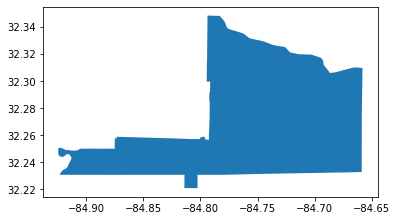

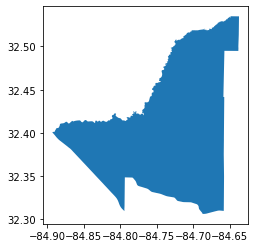

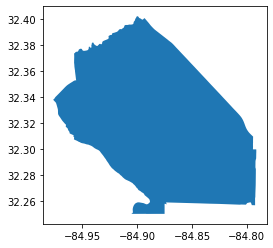

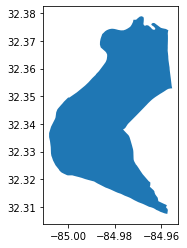

In [215]:
print(ga_shapefile[ga_shapefile["CTYNAME"]=="CHATTAHOOCHEE"])
ga_shapefile[ga_shapefile["CTYNAME"]=="CHATTAHOOCHEE"].plot()
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"].plot()
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"].plot()
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"].plot()

In [216]:
index_fort_1 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"].index.values[0]
index_fort_2 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"].index.values[0]
index_fort_3 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"].index.values[0]

prec2combine = [ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs)

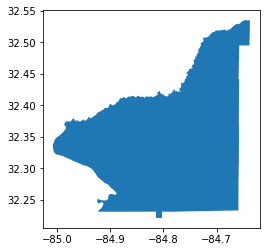

In [217]:
ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER","geometry"]=new_fort.unary_union
ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER","unique_ID"]="053-ACTIVITY CENTER (Includes FTBEN 1-3)"
ga_shapefile.loc[ga_shapefile["unique_ID"]=="053-ACTIVITY CENTER (Includes FTBEN 1-3)"].plot()
ga_shapefile = ga_shapefile.drop([index_fort_1,index_fort_2,index_fort_3])
ga_shapefile.reset_index(drop=True, inplace=True)

#### Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary
All of the merges seem to have already been completed, VEST doesn't provide much detail on the 2/13 boundary adjustment, but it's reasonable to assume that that's also been performed, as the others have been.

In [218]:
print(ga_shapefile[ga_shapefile["CTYNAME"]=="BARROW"])

     DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER2 FIPS2  \
1837    01303    01303         03         03  BARROW        007   013   
1838    01304    01304         04         04  BARROW        007   013   
2579    01302    01302         02         02  BARROW        007   013   
2617    01305    01305         05         05  BARROW        007   013   
2622    01313    01313         13         13  BARROW        007   013   
2623    01308    01308         08         08  BARROW        007   013   
2624    01316    01316         16         16  BARROW        007   013   
2626    01301    01301         01         01  BARROW        007   013   

                                               geometry unique_ID  
1837  POLYGON ((-83.84680 34.05722, -83.84665 34.057...    013-03  
1838  POLYGON ((-83.82042 34.00577, -83.82042 34.005...    013-04  
2579  POLYGON ((-83.83301 34.09043, -83.83298 34.090...    013-02  
2617  POLYGON ((-83.57079 33.94794, -83.57081 33.947...    013-05  
26

#### Bartow: Split Cassville/Hamilton Crossing
This seems to have been performed already in the shapefile.

In [219]:
ga_shapefile[(ga_shapefile["CTYNAME"]=="BARTOW") & (ga_shapefile["PRECINCT_N"].isin(["CASSVILLE","HAMILTON CROSSING"]))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
2390,01517,01517,17,HAMILTON CROSSING,BARTOW,008,015,"POLYGON ((-84.89097 34.22404, -84.89566 34.227...",015-HAMILTON CROSSING
2391,01505,01505,05,CASSVILLE,BARTOW,008,015,"MULTIPOLYGON (((-84.82072 34.20737, -84.82102 ...",015-CASSVILLE


#### Candler: Merge Candler/Metter as Jack Strickland Comm Center
This seems to have been performed already in the shapefile.

In [220]:
ga_shapefile[ga_shapefile["CTYNAME"]=="CANDLER"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1371,043CAND,043CAND,CAND,JACK STRICKLAND COMMUNITY CENTER,CANDLER,021,043,"POLYGON ((-81.93971 32.42674, -81.93972 32.426...",043-JACK STRICKLAND COMMUNITY CENTER


#### Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C
All of the splits seem to have already been completed, VEST doesn't provide much detail on the realignment, but it's reasonable to assume that that's also been performed, as the others have been.

In [221]:
ga_shapefile[(ga_shapefile["CTYNAME"]=="CHATHAM") & (ga_shapefile["PRECINCT_I"].str[0:4].isin(["7-07","8-16","7-12","7-16"]))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1702,0517-16C,0517-16C,7-16C,POOLER RECREATION CENTER GYMNASIUM,CHATHAM,025,051,"POLYGON ((-81.30470 32.09313, -81.30247 32.092...",051-POOLER RECREATION CENTER GYMNASIUM
1703,0517-12C,0517-12C,7-12C,POOLER RECREATION CENTER GYMNASIUM,CHATHAM,025,051,"MULTIPOLYGON (((-81.24078 32.08290, -81.24100 ...",051-POOLER RECREATION CENTER GYMNASIUM
1723,0517-07C,0517-07C,7-07C,ROTHWELL BAPTIST CHURCH,CHATHAM,025,051,"POLYGON ((-81.26321 32.12098, -81.26681 32.122...",051-ROTHWELL BAPTIST CHURCH
1724,0518-16C,0518-16C,8-16C,MIGHTY EIGHTH MUSEUM,CHATHAM,025,051,"POLYGON ((-81.28350 32.16288, -81.28333 32.165...",051-MIGHTY EIGHTH MUSEUM


#### Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile

<AxesSubplot:>

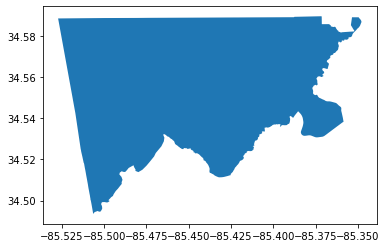

In [222]:
ga_shapefile[ga_shapefile["PRECINCT_N"]=="CLOUDLAND-TELOGA"].plot()

#### Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5 
These changes appear to have been performed already

In [223]:
precinct_list = ["ELLENWOOD 1","ELLENWOOD 2","JONESBORO 1","JONESBORO 17","JONESBORO 19",
                "LOVEJOY 3","LOVEJOY 6", "LOVEJOY 7", "MORROW 3","MORROW 11","MORROW 5", "MORROW 10", "OAK 3", "OAK 5"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="CLAYTON")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
552,063LJ7,063LJ7,LJ7,LOVEJOY 7,CLAYTON,031,063,"POLYGON ((-84.32012 33.42793, -84.32026 33.427...",063-LOVEJOY 7
565,063MO5,063MO5,MO5,MORROW 5,CLAYTON,031,063,"POLYGON ((-84.26368 33.60286, -84.26365 33.602...",063-MORROW 5
566,063MO10,063MO10,MO10,MORROW 10,CLAYTON,031,063,"POLYGON ((-84.27931 33.58589, -84.27982 33.586...",063-MORROW 10
585,063OAK3,063OAK3,OAK3,OAK 3,CLAYTON,031,063,"POLYGON ((-84.41891 33.61936, -84.41736 33.618...",063-OAK 3
654,063LJ3,063LJ3,LJ3,LOVEJOY 3,CLAYTON,031,063,"POLYGON ((-84.38459 33.43340, -84.38433 33.433...",063-LOVEJOY 3
657,063JB19,063JB19,JB19,JONESBORO 19,CLAYTON,031,063,"POLYGON ((-84.39397 33.49235, -84.39416 33.492...",063-JONESBORO 19
658,063JB17,063JB17,JB17,JONESBORO 17,CLAYTON,031,063,"POLYGON ((-84.40796 33.51504, -84.40805 33.515...",063-JONESBORO 17
687,063JB01,063JB01,JB01,JONESBORO 1,CLAYTON,031,063,"POLYGON ((-84.41063 33.51974, -84.41064 33.518...",063-JONESBORO 1
1170,063LJ6,063LJ6,LJ6,LOVEJOY 6,CLAYTON,031,063,"POLYGON ((-84.35375 33.42054, -84.35384 33.420...",063-LOVEJOY 6
2228,063EW2,063EW2,EW2,ELLENWOOD 2,CLAYTON,031,063,"POLYGON ((-84.26289 33.61721, -84.26290 33.616...",063-ELLENWOOD 2


#### Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B

In [224]:
precinct_list = ["BELLS FERRY 03","BELLS FERRY 04","DOBBINS 01","DOBBINS 02",
                "SMYRNA 3A","SMYRNA 3B", "MARIETTA 3A", "MARIETTA 3B"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="COBB")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
172,067F03,067F03,F03,BELLS FERRY 03,COBB,033,067,"POLYGON ((-84.57168 34.07630, -84.57147 34.076...",067-BELLS FERRY 03
181,067I01,067I01,I01,DOBBINS 01,COBB,033,067,"MULTIPOLYGON (((-84.48767 33.91140, -84.48755 ...",067-DOBBINS 01
221,067R3A,067R3A,R3A,MARIETTA 3A,COBB,033,067,"POLYGON ((-84.58508 33.95008, -84.58416 33.950...",067-MARIETTA 3A
272,067N3A,067N3A,N3A,SMYRNA 3A,COBB,033,067,"MULTIPOLYGON (((-84.51435 33.89332, -84.51433 ...",067-SMYRNA 3A


#### Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps

In [225]:
print(ga_shapefile[ga_shapefile["CTYNAME"]=="COLUMBIA"])

     DISTRICT CTYSOSID PRECINCT_I                                  PRECINCT_N  \
487    073131   073131        131                        JOURNEY COMM. CHURCH   
488    073064   073064        064                        GRACE BAPTIST CHURCH   
489    073061   073061        061                             GREENBRIER HIGH   
490    073063   073063        063                            RIVERVIEW CHURCH   
491    073132   073132        132                            WESLEY METHODIST   
492    073135   073135        135                 CHRIST CHURCH, PRESBYTERIAN   
493    073107   073107        107                         GOSPEL WATER BRANCH   
494    073040   073040        040                        EUBANK/BLANCHARD CTR   
693    073109   073109        109                        STEVENS CREEK CHURCH   
702    073111   073111        111                             LAKESIDE MIDDLE   
703    073136   073136        136                        BLUERIDGE ELEMENTARY   
704    073137   073137      

#### Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre

In [226]:
ga_shapefile[ga_shapefile["PRECINCT_N"]=="THE NEWNAN CENTRE"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1140,07718,07718,18,THE NEWNAN CENTRE,COWETA,038,077,"POLYGON ((-84.68711 33.36559, -84.68728 33.365...",077-THE NEWNAN CENTRE


#### Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035

In [242]:
precinct_list = ["121CP07A","121CP07D","121CH01","121CH04B",
                "121SS29A","121SS29B", "121UC031", "121UC035"]

ga_shapefile[(ga_shapefile["DISTRICT"].isin(precinct_list))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
537,121CH04B,None,None,None,None,None,None,"POLYGON ((-84.66472 33.54058, -84.66442 33.540...",121-CH04B
608,121UC031,121UC031,UC031,UC031,FULTON,060,121,"POLYGON ((-84.51855 33.59117, -84.51853 33.592...",121-UC031
611,121UC035,None,None,None,None,None,None,"MULTIPOLYGON (((-84.50786 33.58318, -84.50733 ...",121-UC035
628,121CH01,121CH01,CH01,CH01,FULTON,060,121,"MULTIPOLYGON (((-84.66985 33.54568, -84.66988 ...",121-CH01
2108,121SS29B,None,None,None,None,None,None,"POLYGON ((-84.34772 33.96030, -84.34804 33.960...",121-SS29B
2337,121CP07A,None,None,None,None,None,None,"POLYGON ((-84.48674 33.64957, -84.48684 33.651...",121-CP07A
2367,121CP07D,121CP07D,CP07D,CP07D,FULTON,060,121,"POLYGON ((-84.47553 33.64713, -84.47562 33.647...",121-CP07D
2414,121SS29A,121SS29A,SS29A,SS29A,FULTON,060,121,"POLYGON ((-84.34782 33.94024, -84.34782 33.939...",121-SS29A


#### DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits 
Not enough info given here to recreate

In [228]:
"CLARKSTON"
print(ga_shapefile[(ga_shapefile["CTYNAME"]=="DEKALB") & (ga_shapefile["PRECINCT_N"].str[0:1]=="C")])

    DISTRICT CTYSOSID PRECINCT_I                      PRECINCT_N CTYNAME  \
306   0890CP   0890CP        0CP                      CROSSROADS  DEKALB   
310   0890CM   0890CM        0CM                 COLUMBIA MIDDLE  DEKALB   
320   0890CW   0890CW        0CW                       CORALWOOD  DEKALB   
330   0890CR   0890CR        0CR              CEDAR GROVE MIDDLE  DEKALB   
337   0890CA   0890CA        0CA                  COLUMBIA DRIVE  DEKALB   
341   0890CB   0890CB        0CB                 CANBY LANE ELEM  DEKALB   
343   0890CC   0890CC        0CC                   COLUMBIA ELEM  DEKALB   
346   0890CD   0890CD        0CD                CEDAR GROVE ELEM  DEKALB   
347   0890CE   0890CE        0CE                  CHAMBLEE (CHA)  DEKALB   
348   0890CF   0890CF        0CF  CANDLER - MURPHEY CANDLER ELEM  DEKALB   
351   0890CG   0890CG        0CG                CHAPEL HILL ELEM  DEKALB   
353   0890CH   0890CH        0CH              CHESNUT ELEM (DUN)  DEKALB   
355   0890CI

#### Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G
There isn't enough detail to check these changes.

#### Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU

In [229]:
ga_shapefile[ga_shapefile["CTYNAME"]=="LOWNDES"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1256,185012,185012,012,NORTHGATE ASSEMBLY,LOWNDES,092,185,"POLYGON ((-83.24813 30.99291, -83.24826 30.993...",185-NORTHGATE ASSEMBLY
1264,185007,185007,007,CLYATTVILLE,LOWNDES,092,185,"POLYGON ((-83.45643 30.78682, -83.45589 30.787...",185-CLYATTVILLE
1295,185009,185009,009,S LOWNDES,LOWNDES,092,185,"POLYGON ((-83.13575 30.64111, -83.13662 30.625...",185-S LOWNDES
1296,185008,185008,008,DASHER,LOWNDES,092,185,"POLYGON ((-83.13527 30.76853, -83.13516 30.768...",185-DASHER
1297,185004,185004,004,NAYLOR,LOWNDES,092,185,"POLYGON ((-83.09403 30.83124, -83.10323 30.831...",185-NAYLOR
1299,185001,185001,001,HAHIRA TRAIN DEPOT,LOWNDES,092,185,"POLYGON ((-83.26666 31.02672, -83.26194 31.026...",185-HAHIRA TRAIN DEPOT
1303,185006,185006,006,MILDRED,LOWNDES,092,185,"POLYGON ((-83.28026 30.83020, -83.27995 30.830...",185-MILDRED
1304,185013,185013,013,MT CALVARY,LOWNDES,092,185,"POLYGON ((-83.23113 30.87883, -83.23096 30.878...",185-MT CALVARY
1305,185011,185011,011,JAYCEE SHACK,LOWNDES,092,185,"POLYGON ((-83.25038 30.88168, -83.25047 30.881...",185-JAYCEE SHACK
1306,185002,185002,002,TRINITY,LOWNDES,092,185,"POLYGON ((-83.26498 30.97960, -83.26484 30.979...",185-TRINITY


#### Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits

In [230]:
ga_shapefile[ga_shapefile["CTYNAME"]=="OCONEE"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
507,21903,21903,03,ANTIOCH,OCONEE,108,219,"POLYGON ((-83.35190 33.71521, -83.35708 33.713...",219-ANTIOCH
508,21902,21902,02,COLHAM FERRY,OCONEE,108,219,"POLYGON ((-83.32129 33.85460, -83.32045 33.854...",219-COLHAM FERRY
2554,21905,21905,05,BISHOP,OCONEE,108,219,"POLYGON ((-83.47579 33.79612, -83.47570 33.796...",219-BISHOP
2555,21912,21912,12,CIVIC CENTER,OCONEE,108,219,"POLYGON ((-83.43578 33.84933, -83.43586 33.849...",219-CIVIC CENTER
2556,21910,21910,10,MARSWOOD HALL,OCONEE,108,219,"POLYGON ((-83.47009 33.93095, -83.46996 33.931...",219-MARSWOOD HALL
2558,21901,21901,01,CITY HALL,OCONEE,108,219,"POLYGON ((-83.35806 33.87485, -83.35699 33.874...",219-CITY HALL
2564,21904,21904,04,FARMINGTON,OCONEE,108,219,"POLYGON ((-83.39124 33.70294, -83.39522 33.701...",219-FARMINGTON
2582,21911,21911,11,EAST OCONEE,OCONEE,108,219,"POLYGON ((-83.40174 33.91087, -83.40144 33.910...",219-EAST OCONEE
2613,21908,21908,08,DARK CORNER,OCONEE,108,219,"POLYGON ((-83.64585 33.90685, -83.64434 33.907...",219-DARK CORNER
2614,21906,21906,06,HIGH SHOALS,OCONEE,108,219,"POLYGON ((-83.50223 33.81723, -83.50240 33.817...",219-HIGH SHOALS


#### Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019

In [231]:
ga_shapefile[ga_shapefile["CTYNAME"]=="PAULDING"].shape

(19, 9)

#### Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman

In [232]:
ga_shapefile[ga_shapefile["CTYNAME"]=="RANDOLPH"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
643,243131,243131,131,COLEMAN,RANDOLPH,120,243,"POLYGON ((-84.92013 31.61864, -84.92276 31.618...",243-COLEMAN
885,243334,243334,334,SHELLMAN,RANDOLPH,120,243,"POLYGON ((-84.66683 31.62006, -84.66747 31.620...",243-SHELLMAN
889,243954,243954,954,SPRINGVALE,RANDOLPH,120,243,"POLYGON ((-84.95864 31.77755, -84.95864 31.777...",243-SPRINGVALE
890,243718B,243718B,718B,CUTHBERT,RANDOLPH,120,243,"POLYGON ((-84.79549 31.76895, -84.79536 31.768...",243-CUTHBERT
891,243566,243566,566,BENEVOLENCE,RANDOLPH,120,243,"POLYGON ((-84.68127 31.77297, -84.68336 31.772...",243-BENEVOLENCE
895,243718A,243718A,718A,CUTHBERT/COURTHOUSE,RANDOLPH,120,243,"POLYGON ((-84.70139 31.61988, -84.70780 31.619...",243-CUTHBERT/COURTHOUSE


#### Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps

In [233]:
ga_shapefile[ga_shapefile["CTYNAME"]=="TROUP"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
619,28515,28515,15,HIGHLAND,TROUP,141,285,"POLYGON ((-85.02925 33.00490, -85.02920 33.006...",285-HIGHLAND
633,28512,28512,12,GARDNER NEWMAN,TROUP,141,285,"POLYGON ((-84.91251 33.04024, -84.91246 33.039...",285-GARDNER NEWMAN
971,28505,28505,05,WEST POINT,TROUP,141,285,"POLYGON ((-85.17470 32.87050, -85.17486 32.870...",285-WEST POINT
973,28511,28511,11,LONG CANE,TROUP,141,285,"POLYGON ((-85.07493 32.96765, -85.07468 32.967...",285-LONG CANE
974,28513,28513,13,GRAY HILL,TROUP,141,285,"POLYGON ((-85.09944 32.86951, -85.09941 32.866...",285-GRAY HILL
1009,28502,28502,02,ADMINISTRATION BLDG,TROUP,141,285,"POLYGON ((-85.03674 33.03872, -85.03654 33.038...",285-ADMINISTRATION BLDG
1010,28504,28504,04,GRIGGS CENTER,TROUP,141,285,"POLYGON ((-85.03205 33.03874, -85.03114 33.038...",285-GRIGGS CENTER
1011,28508,28508,08,ROSEMONT,TROUP,141,285,"POLYGON ((-84.94925 32.86899, -84.96499 32.869...",285-ROSEMONT
1021,28516,28516,16,NORTHSIDE,TROUP,141,285,"POLYGON ((-85.07638 33.07814, -85.07666 33.078...",285-NORTHSIDE
1023,28503,28503,03,HAMMETT RD,TROUP,141,285,"POLYGON ((-85.00387 33.04356, -85.00433 33.043...",285-HAMMETT RD


#### Towns: Merge Macedonia/Tate City

In [234]:
ga_shapefile[ga_shapefile["CTYNAME"]=="TOWNS"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1873,2811468,2811468,1468,YOUNG HARRIS,TOWNS,139,281,"POLYGON ((-83.92092 34.98740, -83.92048 34.987...",281-YOUNG HARRIS
2651,281990,281990,990,HIAWASSEE,TOWNS,139,281,"POLYGON ((-83.85026 34.98148, -83.85002 34.981...",281-HIAWASSEE
2652,281833,281833,833,MACEDONIA,TOWNS,139,281,"POLYGON ((-83.65374 34.82063, -83.65381 34.820...",281-MACEDONIA


In [235]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2379
left_only      300
right_only     297
Name: _merge, dtype: int64


In [236]:
example_csv = pd.read_csv("./shp_id_changes.csv")
example_fips_dict = dict(zip(example_csv["shp_ID"],example_csv["election_ID"]))

ga_shapefile["unique_ID"] = ga_shapefile["unique_ID"].map(example_fips_dict).fillna(ga_shapefile["unique_ID"])

In [237]:
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [238]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

ga_source = join_attempt_3[join_attempt_3["_merge"]=="both"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2670
left_only       10
right_only       6
Name: _merge, dtype: int64


In [239]:
left_only_list = list(left_only["unique_ID"])
print(ga_election[ga_election["unique_ID"].isin(left_only_list)]["unique_ID"])

303                 051-POOLER CHURCH
324                     055-CLOUDLAND
334                        055-TELOGA
485                067-BELLS FERRY 04
504                    067-DOBBINS 02
552                   067-MARIETTA 3B
603                     067-SMYRNA 3B
793    089-CLARKSTON COMMUNITY CENTER
804                       089-DECATUR
951                         121-CP053
Name: unique_ID, dtype: object


In [240]:
right_only_list = list(right_only["unique_ID"])
print(ga_shapefile[(ga_shapefile["unique_ID"].isin(right_only_list))&(ga_shapefile["unique_ID"].str[0:3]!="121")]["unique_ID"])
print(ga_shapefile[(ga_shapefile["unique_ID"].isin(right_only_list))&(ga_shapefile["unique_ID"].str[0:3]=="121")]["unique_ID"])

379     089-RENFROE MIDDLE (DEC)
1981        055-CLOUDLAND-TELOGA
Name: unique_ID, dtype: object
537     121-CH04B
611     121-UC035
2108    121-SS29B
2337    121-CP07A
Name: unique_ID, dtype: object


9556719.170992693

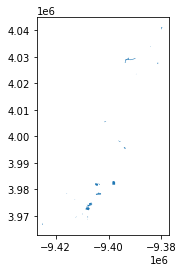

In [124]:
fulton_remaining = ga_shapefile[(ga_shapefile["unique_ID"].isin(right_only_list))&(ga_shapefile["unique_ID"].str[0:3]=="121")]
fulton_remaining = fulton_remaining.to_crs(3857)
fulton_remaining.plot()
sum(fulton_remaining.area)

In [141]:
ga_shapefile

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
0,135001,135001,001,HARBINS A,GWINNETT,067,135,"POLYGON ((-83.92720 33.95932, -83.92718 33.959...",135-HARBINS A
1,135002,135002,002,ROCKBRIDGE A,GWINNETT,067,135,"POLYGON ((-84.07069 33.80553, -84.06961 33.805...",135-ROCKBRIDGE A
2,135003,135003,003,DACULA,GWINNETT,067,135,"POLYGON ((-83.93919 33.97860, -83.93773 33.979...",135-DACULA
3,135004,135004,004,SUWANEE A,GWINNETT,067,135,"POLYGON ((-84.09215 34.04908, -84.09206 34.049...",135-SUWANEE A
4,135028,135028,028,ROCKYCREEK A,GWINNETT,067,135,"POLYGON ((-83.91067 34.01586, -83.91052 34.016...",135-ROCKYCREEK A
...,...,...,...,...,...,...,...,...,...
2692,11735,11735,35,35 JOHNS CREEK,FORSYTH,058,117,"POLYGON ((-84.14664 34.05659, -84.14759 34.057...",117-35 JOHNS CREEK
2693,11719,11719,19,19 OLD ATLANTA,FORSYTH,058,117,"POLYGON ((-84.13691 34.10059, -84.13570 34.101...",117-19 OLD ATLANTA
2694,11721,11721,21,21 SOUTH FORSYTH,FORSYTH,058,117,"POLYGON ((-84.17506 34.11764, -84.17503 34.117...",117-21 SOUTH FORSYTH
2695,11736,11736,36,36 NICHOLS,FORSYTH,058,117,"POLYGON ((-84.13570 34.10106, -84.13691 34.100...",117-36 NICHOLS


In [243]:
final_merge = pd.merge(ga_source,vest_ga_20,how="outer",on="unique_ID",indicator="final_merge")

print(final_merge["final_merge"].value_counts())

both          2670
right_only      10
left_only        0
Name: final_merge, dtype: int64


In [244]:
vest_only_list = list(final_merge[final_merge["final_merge"]=="right_only"]["unique_ID"])
vest_ga_20[vest_ga_20["unique_ID"].isin(vest_only_list)]["unique_ID"]

951                          121-CP053
1871                     055-CLOUDLAND
1881                        055-TELOGA
1896                 051-POOLER CHURCH
2090                       089-DECATUR
2093    089-CLARKSTON COMMUNITY CENTER
2655                067-BELLS FERRY 04
2656                    067-DOBBINS 02
2659                   067-MARIETTA 3B
2660                     067-SMYRNA 3B
Name: unique_ID, dtype: object

121-CP053
055-CLOUDLAND
055-TELOGA
051-POOLER CHURCH
089-DECATUR
089-CLARKSTON COMMUNITY CENTER
067-BELLS FERRY 04
067-DOBBINS 02
067-MARIETTA 3B
067-SMYRNA 3B


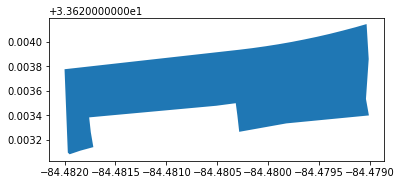

In [267]:
for i in vest_only_list:
    print(i)
    if i[0:3]=="121":
        vest_ga_20[vest_ga_20["unique_ID"]==i].plot()

089-RENFROE MIDDLE (DEC)
055-CLOUDLAND-TELOGA


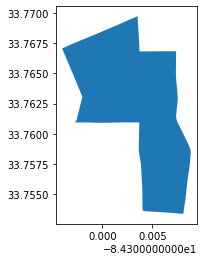

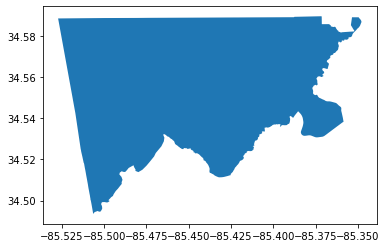

In [246]:
right_only_list = list(right_only["unique_ID"])

for i in right_only_list:
    if i[0]!="1":
        print(i)
        ga_shapefile[ga_shapefile["unique_ID"]==i].plot()

In [247]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_ga_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_ga_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    2190
True      480
dtype: int64


1) For 021-HAZZARD 4 difference in area is 3.3706615343443707
2) For 021-HOWARD 1 difference in area is 5.036147171439918
3) For 021-HOWARD 2 difference in area is 2.5699095162291674
4) For 021-HOWARD 3 difference in area is 1.5699552273580146
5) For 021-HOWARD 5 difference in area is 0.5171174601516663
6) For 051-LAKE SHORE COMM CTR difference in area is 1.8155223560836502
7) For 051-RICE CREEK SCHOOL difference in area is 1.8110601544647957
8) For 051-POOLER REC CENTER GYM difference in area is 3.5429986118187844
9) For 067-BELLS FERRY 03 difference in area is 0.7435728376865838
10) For 067-DOBBINS 01 difference in area is 0.5291437226811758
11) For 073-PARKWAY BAPTIST CHURCH difference in area is 0.5694240817096237
12) For 073-PATRIOTS PARK difference in area is 0.859698204711429
Not able to run code for:  089-GLENNWOOD
13) For 223-BEULAHLAND BAPTIST CHURCH difference in area is 1.9718280831816215
14) For 223-WATSON GOVT CMPLX difference in area is 2.2743294610128006
15) For 285-LON

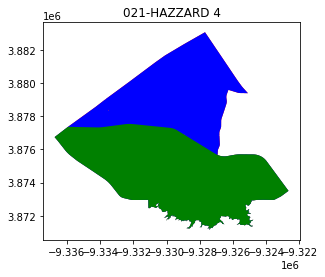

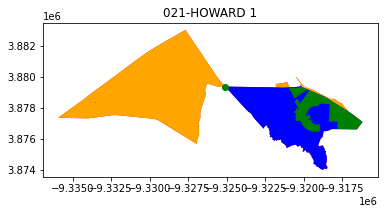

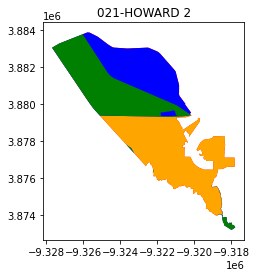

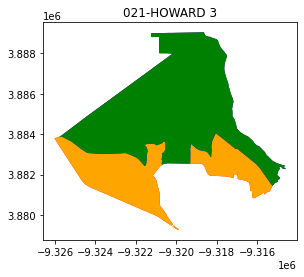

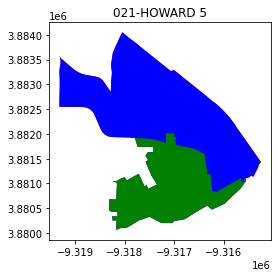

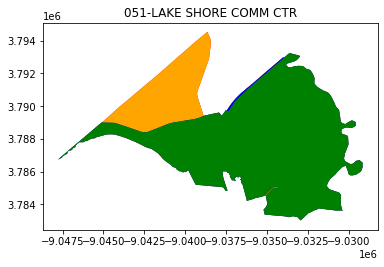

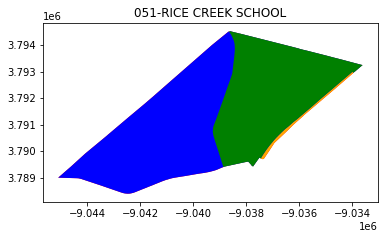

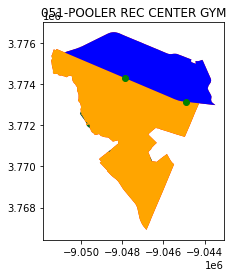

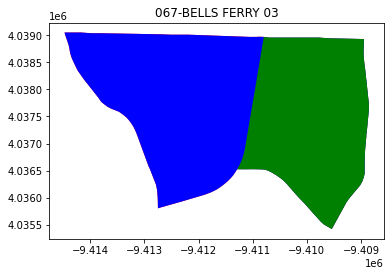

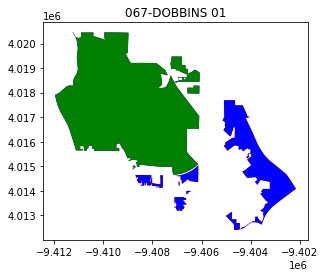

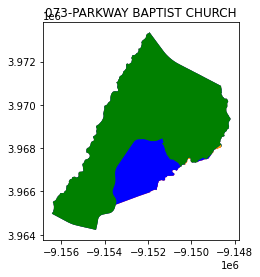

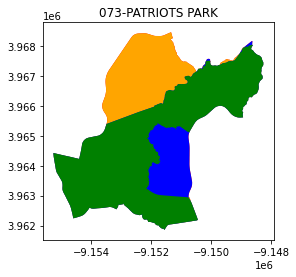

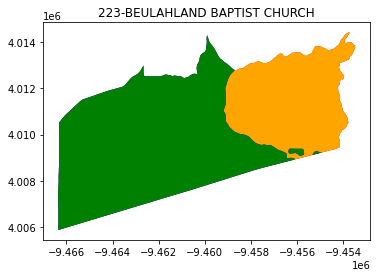

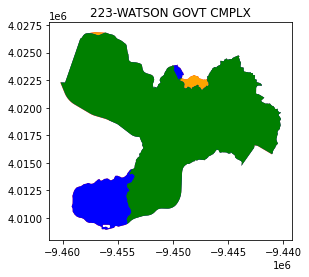

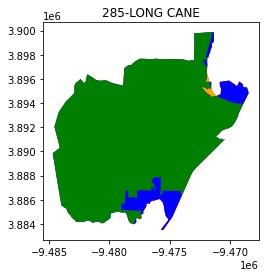

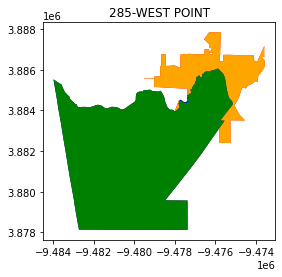

In [248]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    try:
        diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
        intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)
            #print("Area is " + str(area))

        if (area > .5):
            count += 1
            name = source_geoms.iat[i,0]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
    except:
        print("Not able to run code for: ", source_geoms.iat[i,0])
        #diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])


In [111]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2668, 1)
1641 precincts w/ a difference of 0 km^2
989 precincts w/ a difference between 0 and .1 km^2
22 precincts w/ a difference between .1 and .5 km^2
6 precincts w/ a difference between .5 and 1 km^2
5 precincts w/ a difference between 1 and 2 km^2
4 precincts w/ a difference between 2 and 5 km^2
1 precincts w/ a difference greater than 5 km^2
